In [1]:
#first attempt at decoding using 8-fold cross-validation

config


Please enter DataJoint username:  root
Please enter DataJoint password:  ···············


Connecting root@localhost:3306
Epiphyte Setup


In [ ]:
import os
import glob
import time 
import copy
import pickle
import random
import sklearn
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 
from sklearn.inspection import permutation_importance
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, roc_curve, auc, plot_confusion_matrix
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV
from mlxtend.plotting import plot_decision_regions

import utils.helper_func as hf
import utils.plotting as plotting
import utils.decoding as decoding

warnings.filterwarnings("ignore")

In [2]:
patient_id = 46
session_nr = 1

#top_dir = '/media/alado/TOSHIBA_EXT/thesis/output'
top_dir = '/home/anastasia/epiphyte/anastasia/output'
folder = f'05-Hilbert_transform_{patient_id}'
filtering_type = ['theta', 'slow_gamma', 'fast_gamma']

fs = 32768
#The resulting sample rate is up / down times the original sample rate.
up = 1
down=32
fs_downs = (up/down)*fs
dt = 1/fs_downs      # sampling period/time/interval or time resolution, often denoted as T

times = np.linspace(-500, 1000, num = 1501)
time_zero_idx = np.where(times == hf.find_nearest(times, 0))[0][0]

df_patient_info = pd.read_csv(f'{top_dir}/{patient_id}_channel_info.csv')
dict_replace = {'LA1':'LAA1', 'LA2':'LAA2', 'LA3':'LAA3', 'LA4':'LAA4', 'LA5':'LAA5', 'LA6':'LAA6', 'LA7':'LAA7', 'LA8':'LAA8',
               'RA1':'RAA1', 'RA2':'RAA2', 'RA3':'RAA3', 'RA4':'RAA4', 'RA5':'RAA5', 'RA6':'RAA6', 'RA7':'RAA7', 'RA8':'RAA8',}
df_patient_info_new = df_patient_info.replace(dict_replace)
df_stim_info = pd.read_csv(f'{top_dir}/{patient_id}_df_stim_info.csv')
all_stim = np.unique(df_stim_info['stim_id'])
all_stim_name = np.unique(df_stim_info['stim_name'])
all_brain_areas = np.unique(df_patient_info['recording_site'])
#brain_areas = ['LAA', 'LAH', 'LEC','LMH', 'LPHC', 'RAA', 'RAH', 'REC', 'RMH', 'RPHC']
brain_areas = np.unique(df_patient_info['brain_area'])

n_channels = 80
n_stim_present = 10
n_stim = 42

In [3]:
time_chunks = ['200_500', '500_800', '200_600', '400_800']
time_chunks_dict = {'200_500_st':700, '200_500_end':1000, '500_800_st':1000, '500_800_end':1300, 
                    '200_600_st':700, '200_600_end':1100,'400_800_st':900, '400_800_end':1300}
n_pca_comp = 10

columns_data_array = []
for j in filtering_type:
    for i in range(len(df_patient_info['channel_name'])):
        ch = df_patient_info.loc[i,'channel_name']
        ch_site = df_patient_info.loc[i,'recording_site']
        
        for tm in time_chunks:
            columns_data_array.append(f'{j}_{ch}_{tm}')
        
        for comp in range(n_pca_comp):
            columns_data_array.append(f'{j}_{ch}_pca_{comp+1}')

In [4]:
for i in range(len(df_patient_info['channel_name'])):
    ch = df_patient_info.loc[i,'channel_name']
    ch_site = df_patient_info.loc[i,'recording_site']
    
    path = f'{top_dir}/{folder}/theta/envelope/{ch}_{ch_site}'
    file_1 = f'{path}/{ch}_{ch_site}_38_???_amplitude_envelope_pre.npy'
    file_2 = f'{path}/{ch}_{ch_site}_38_unknown_amplitude_envelope_pre.npy'
    os.rename(file_1, file_2)

FileNotFoundError: [Errno 2] No such file or directory: '/home/anastasia/epiphyte/anastasia/output/05-Hilbert_transform_46/theta/envelope/CSC1_LA1/CSC1_LA1_38_???_amplitude_envelope_pre.npy' -> '/home/anastasia/epiphyte/anastasia/output/05-Hilbert_transform_46/theta/envelope/CSC1_LA1/CSC1_LA1_38_unknown_amplitude_envelope_pre.npy'

In [5]:
if os.path.isfile(f'{top_dir}/06-decoding_{patient_id}/df_data_post.csv'):
    df_data_post = pd.read_csv(f'{top_dir}/06-decoding_{patient_id}/df_data_post.csv')
    df_stimuli = pd.read_csv(f'{top_dir}/06-decoding_{patient_id}/df_stimuli.csv')
else:
    n_pca_components = 10
    df_data_pre = decoding.create_data_df(df_stim_info, df_patient_info, all_stim, filtering_type, time_chunks, time_chunks_dict, columns_data_array, folder, n_pca_components, 'pre', pca=True)
    df_data_post, df_stimuli = decoding.create_data_df(df_stim_info, df_patient_info, all_stim, filtering_type, time_chunks, time_chunks_dict, columns_data_array, folder, n_pca_components, 'post', pca=True)
    df_data_post.to_csv(f'{top_dir}/06-decoding_{patient_id}/df_data_post.csv')
    df_stimuli.to_csv(f'{top_dir}/06-decoding_{patient_id}/df_stimuli.csv')

In [6]:
n_pca_components = 10
df_data_pre = decoding.create_data_df(df_stim_info, df_patient_info, all_stim, filtering_type, time_chunks, time_chunks_dict, columns_data_array, folder, n_pca_components, 'pre', pca=True)
df_data_post, df_stimuli = decoding.create_data_df(df_stim_info, df_patient_info, all_stim, filtering_type, time_chunks, time_chunks_dict, columns_data_array, folder, n_pca_components, 'post', pca=True)
df_data_post.to_csv(f'{top_dir}/06-decoding_{patient_id}/df_data_post.csv')
df_stimuli.to_csv(f'{top_dir}/06-decoding_{patient_id}/df_stimuli.csv')

In [7]:
#percentage of stimuli
#movie vs non-movie
arr = [brain_areas[:5], brain_areas[5:]]
movie_stim = df_stimuli['is_500_days'].sum() / 10
movie_stim_percentage = (movie_stim*100)/42
non_movie_stim_percentage = 100 - movie_stim_percentage
non_movie_stim_percentage

23.80952380952381

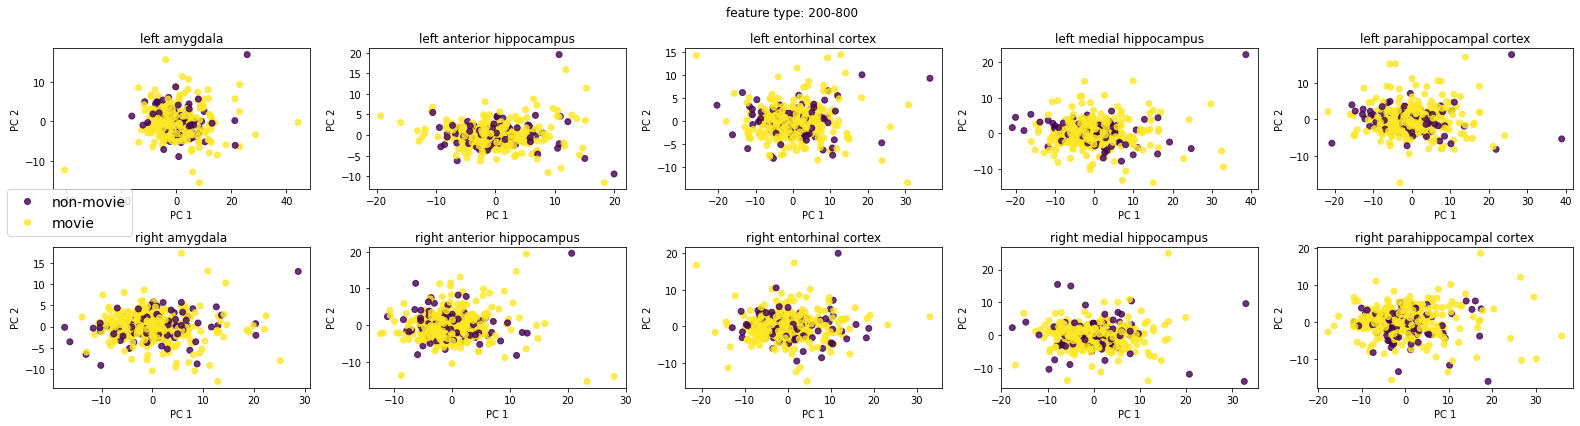

In [26]:
classes = ['non-movie', 'movie']
fig, axes = plt.subplots(2,5, figsize=(22,6))
feature_type = '200-800'
fig.suptitle(f'feature type: {feature_type}')
for a in range(len(arr)):
    br_areas = arr[a]
    for j in range(len(br_areas)):
        if a == 0:
            brain_area = brain_areas[j]
        else:
            brain_area = brain_areas[j+5]
        channel_cols = df_patient_info.loc[df_patient_info_new['brain_area'].str.contains(brain_area)]
        channel_cols = channel_cols.reset_index()
        cols_to_use = []
        for filt in filtering_type:
            for i in range(len(channel_cols)):
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600')
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_400_800') 
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_500')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_500_800')                
                #for j in range (1, n_pca_components):
                #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

        #for multiclass one-vs-one: belongs to movie or not
        X = df_data_post[df_data_post.columns & cols_to_use]
        y = df_stimuli['is_500_days']

        #2D PCA scatter plot
        pca = PCA(n_components=2)
        components = pca.fit_transform(X)

        scatter = axes[a,j].scatter(components[:,0], components[:,1], c=df_stimuli['is_500_days'], alpha=0.8)
        axes[a,j].set_title(f'{brain_area}')
        axes[a,j].set_xlabel('PC 1')
        axes[a,j].set_ylabel('PC 2')
        handles, labels = scatter.legend_elements()
        labels = ['non-movie', 'movie']
        #axes[a,j].legend(handles, labels)

plt.tight_layout()
fig.legend(handles, labels, loc='center left', prop={'size': 14})
plt.show()
fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots/data/post_data_PCA_{feature_type}.png', facecolor='white', transparent=False)

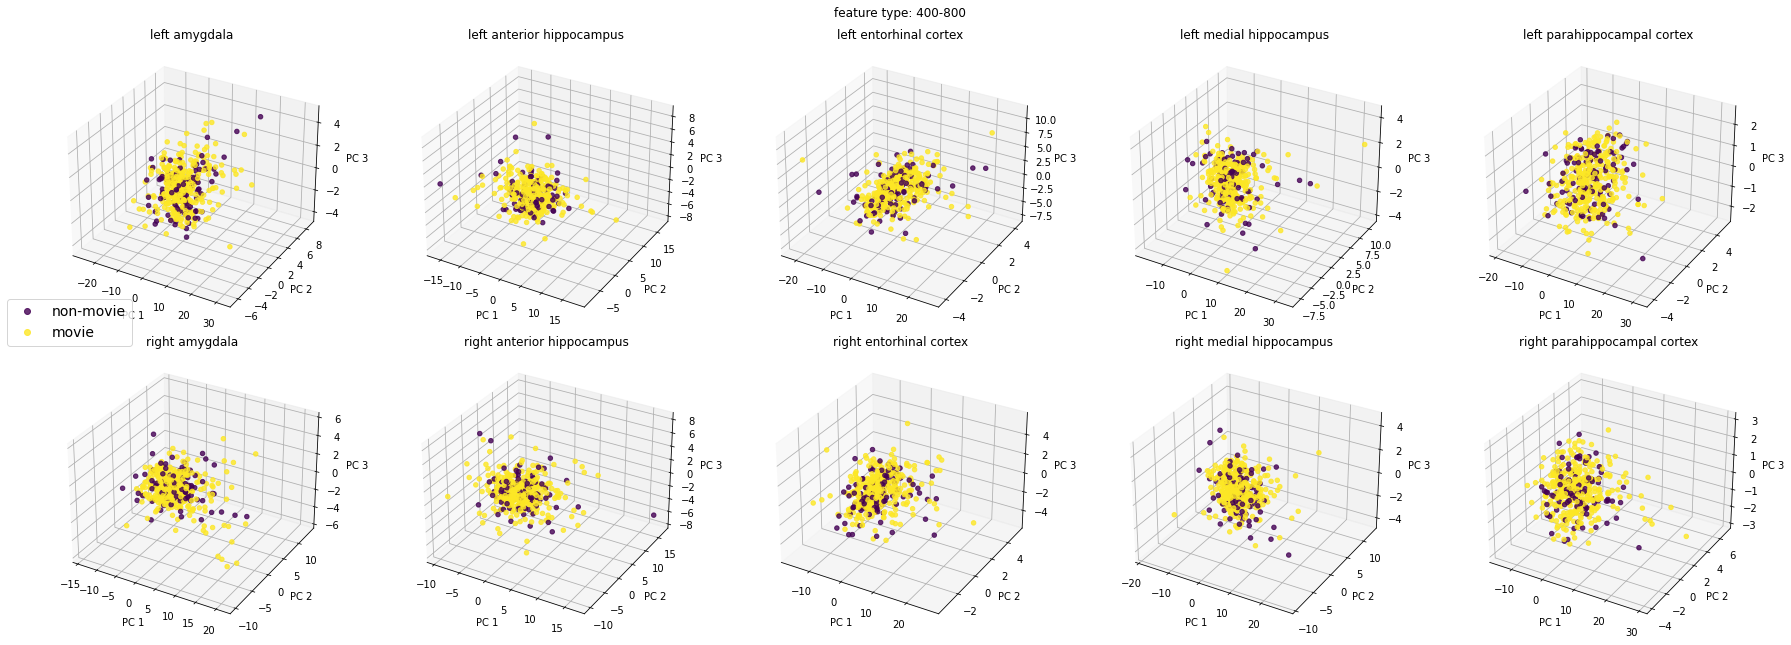

In [29]:
classes = ['non-movie', 'movie']
fig, axes = plt.subplots(2,5, figsize=(25,9), subplot_kw={"projection": "3d"})
feature_type = '400-800'
fig.suptitle(f'feature type: {feature_type}')
for a in range(len(arr)):
    br_areas = arr[a]
    for j in range(len(br_areas)):
        if a == 0:
            brain_area = brain_areas[j]
        else:
            brain_area = brain_areas[j+5]
        channel_cols = df_patient_info.loc[df_patient_info_new['brain_area'].str.contains(brain_area)]
        channel_cols = channel_cols.reset_index()
        cols_to_use = []
        for filt in filtering_type:
            for i in range(len(channel_cols)):
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_400_800') 
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_500')
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_500_800')                
                #for j in range (1, n_pca_components):
                #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

        #for multiclass one-vs-one: belongs to movie or not
        X = df_data_post[df_data_post.columns & cols_to_use]
        y = df_stimuli['is_500_days']

        #3D PCA scatter plot
        pca = PCA(n_components=3)
        components = pca.fit_transform(X)

        scatter = axes[a,j].scatter(components[:,0], components[:,1], components[:,2], c=df_stimuli['is_500_days'], alpha=0.8)
        axes[a,j].set_title(f'{brain_area}')
        axes[a,j].set_xlabel('PC 1')
        axes[a,j].set_ylabel('PC 2')
        axes[a,j].set_zlabel('PC 3')
        handles, labels = scatter.legend_elements()
        labels = ['non-movie', 'movie']
        #axes[a,j].legend(handles, labels)

plt.tight_layout()
fig.legend(handles, labels, loc='center left', prop={'size': 14})
plt.show()
fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots/data/pre_data_PCA3_{feature_type}.png', facecolor='white', transparent=False)


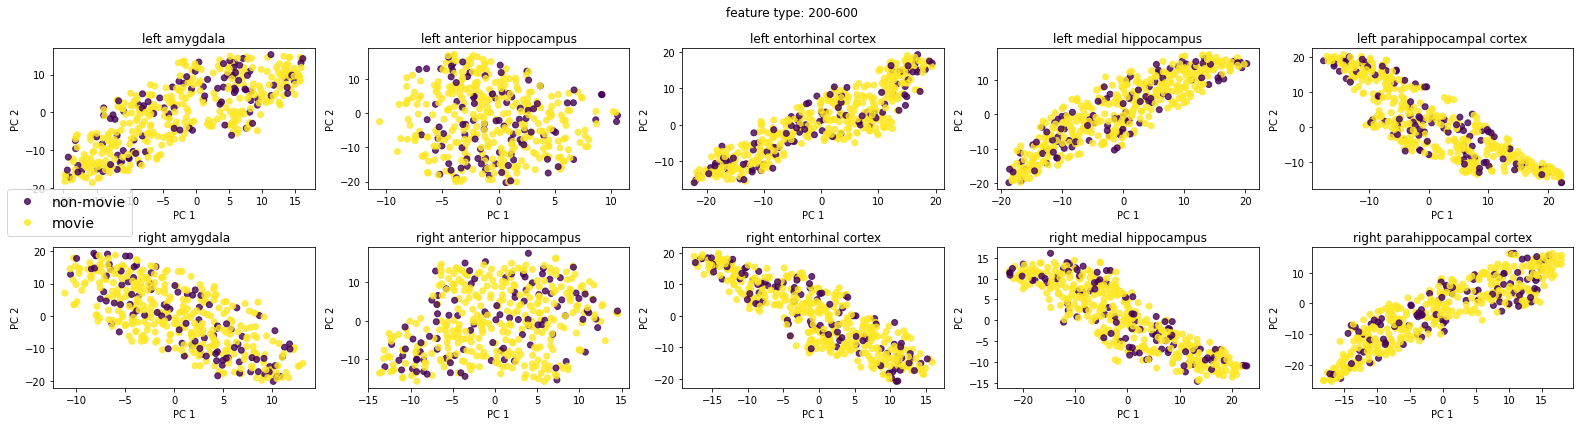

In [33]:
classes = ['non-movie', 'movie']
fig, axes = plt.subplots(2,5, figsize=(22,6))
feature_type = '200-600'
fig.suptitle(f'feature type: {feature_type}')
for a in range(len(arr)):
    br_areas = arr[a]
    for j in range(len(br_areas)):
        if a == 0:
            brain_area = brain_areas[j]
        else:
            brain_area = brain_areas[j+5]
        channel_cols = df_patient_info.loc[df_patient_info_new['brain_area'].str.contains(brain_area)]
        channel_cols = channel_cols.reset_index()
        cols_to_use = []
        for filt in filtering_type:
            for i in range(len(channel_cols)):
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600')
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_400_800') 
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_500')
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_500_800')                
                #for j in range (1, n_pca_components):
                #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

        #for multiclass one-vs-one: belongs to movie or not
        X = df_data_post[df_data_post.columns & cols_to_use]
        y = df_stimuli['is_500_days']

        #2D t-SNE
        tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=5000)
        tsne_results = tsne.fit_transform(X)

        scatter = axes[a,j].scatter(tsne_results[:,0], tsne_results[:,1], c=df_stimuli['is_500_days'], alpha=0.8)
        axes[a,j].set_title(f'{brain_area}')
        axes[a,j].set_xlabel('PC 1')
        axes[a,j].set_ylabel('PC 2')
        handles, labels = scatter.legend_elements()
        labels = ['non-movie', 'movie']
        #axes[a,j].legend(handles, labels)

plt.tight_layout()
fig.legend(handles, labels, loc='center left', prop={'size': 14})
plt.show()
fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots/data/post_data_tSNE_{feature_type}.png', facecolor='white', transparent=False)

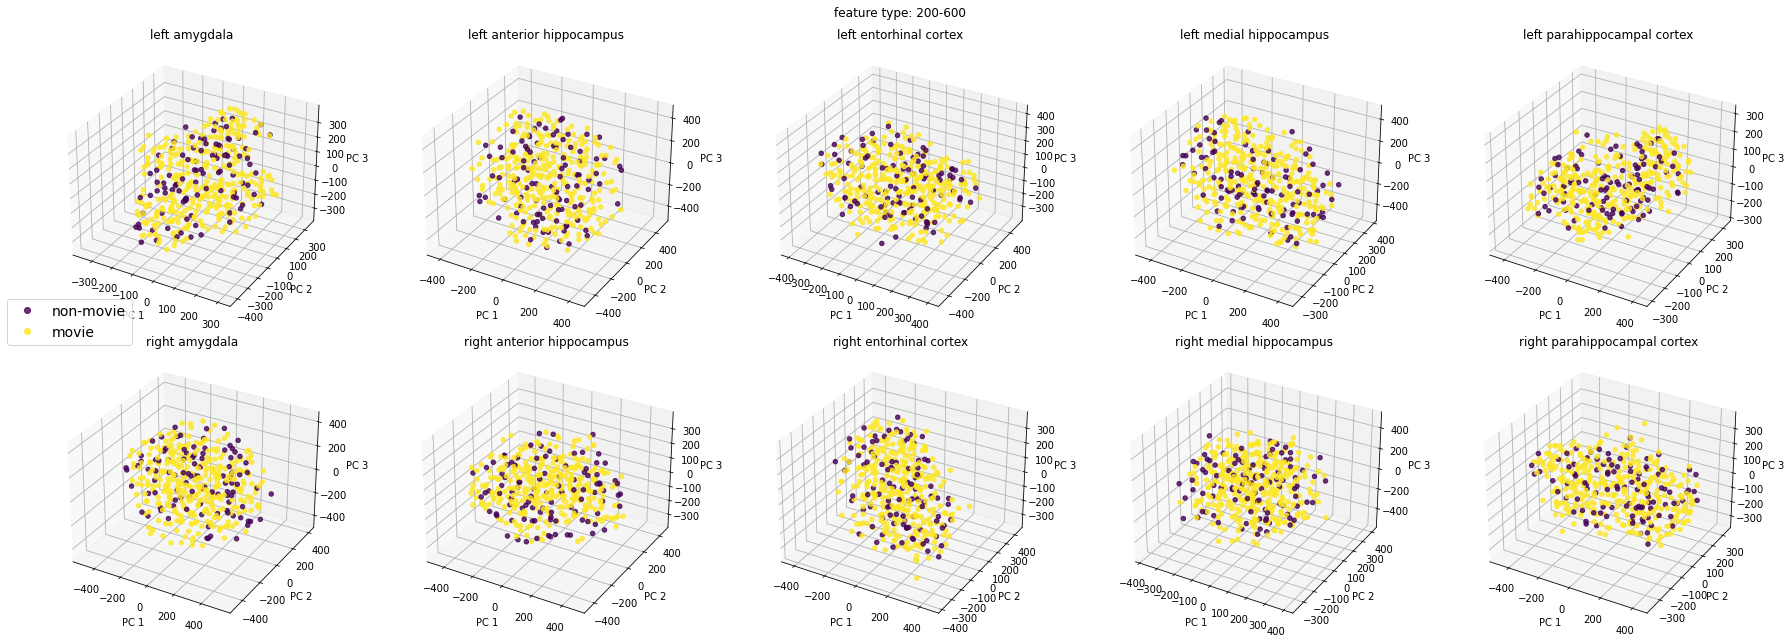

In [35]:
classes = ['non-movie', 'movie']
fig, axes = plt.subplots(2,5, figsize=(25,9), subplot_kw={"projection": "3d"})
feature_type = '200-600'
fig.suptitle(f'feature type: {feature_type}')
for a in range(len(arr)):
    br_areas = arr[a]
    for j in range(len(br_areas)):
        if a == 0:
            brain_area = brain_areas[j]
        else:
            brain_area = brain_areas[j+5]
        channel_cols = df_patient_info.loc[df_patient_info_new['brain_area'].str.contains(brain_area)]
        channel_cols = channel_cols.reset_index()
        cols_to_use = []
        for filt in filtering_type:
            for i in range(len(channel_cols)):
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600')
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_400_800') 
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_500')
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_500_800')                
                #for j in range (1, n_pca_components):
                #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

        #for multiclass one-vs-one: belongs to movie or not
        X = df_data_post[df_data_post.columns & cols_to_use]
        y = df_stimuli['is_500_days']

        #3D t-SNE scatter plot
        tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=5000)
        tsne_results = tsne.fit_transform(X)

        scatter = axes[a,j].scatter(tsne_results[:,0], tsne_results[:,1], tsne_results[:,2], c=df_stimuli['is_500_days'], alpha=0.8)
        axes[a,j].set_title(f'{brain_area}')
        axes[a,j].set_xlabel('PC 1')
        axes[a,j].set_ylabel('PC 2')
        axes[a,j].set_zlabel('PC 3')
        handles, labels = scatter.legend_elements()
        labels = ['non-movie', 'movie']
        #axes[a,j].legend(handles, labels)

plt.tight_layout()
fig.legend(handles, labels, loc='center left', prop={'size': 14})
plt.show()
fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots/data/pre_data_tSNE3_{feature_type}.png', facecolor='white', transparent=False)

In [ ]:
#find highest accuracy and its classifier

In [8]:
#random_seeds = [1, 10, 42, 86, 100]
#random_seeds = [1, 10]
random_seeds = np.linspace(1, 500, 100, dtype=int)
kernels = ['poly', 'linear', 'rbf', 'sigmoid']
strings = []
all_best_params_list = []
best_params_list = []
all_losses = []
for rand_seed in random_seeds:
    print(rand_seed)
    np.random.seed(rand_seed) #for train-test split
    strings.append(rand_seed)
    for brain_area in brain_areas:
        best_params_list_per_area = []
        strings.append(brain_area)
        #print(brain_area)
        channel_cols = df_patient_info.loc[df_patient_info_new['brain_area'].str.contains(brain_area)]
        channel_cols = channel_cols.reset_index()

        best_params = {}

        # Use a K-fold cross validation with different parameters
        # Create all parameter combinations
        params = {'random_state': [rand_seed],
                  'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
                  'loss': ['hinge', 'squared_hinge'],    
                  'penalty': ['l1', 'l2'],
                  #'gamma': ['scale', 'auto'],
                  #'degree': [3]
                 }
        # Create all possible parameter combinations
        combinations_linear = [[i, j, k, l] for i in params['random_state']
                       for j in params['C']
                       for k in params['loss']
                       for l in params ['penalty']]
        for s in reversed(combinations_linear):
            if (s[2] == 'hinge') and (s[3]=='l1'):
                combinations_linear.remove(s)
        combinations = [[i, j] for i in params['random_state']
                       for j in params['C']
                       #for l in params['gamma']
                       #for k in params['degree']
                       ]

        cols_to_use = []
        for filt in filtering_type:
            for i in range(len(channel_cols)):
                #print(for_cols.loc[i,'channel_name'])
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600')
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_500_800')            
                #for j in range (1, n_pca_components):
                #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

        feature_type = '200-600'
        #for multiclass one-vs-one: belongs to movie or not
        X = df_data_post[df_data_post.columns & cols_to_use]
        y = df_stimuli['is_500_days']
        
        best_classifier = []
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
        K=8
        for kernel in kernels:
            errors = np.array([])
            #print(f'{kernel} classifier')
            strings.append(f'{kernel} classifier')            
            if kernel == 'linear':
                losses, avg_loss, classifier = decoding.custom_SVM(X_train, y_train, K, combinations_linear, kernel, rand_seed)
            else:
                losses, avg_loss, classifier = decoding.custom_SVM(X_train, y_train, K, combinations, kernel, rand_seed)   
            
            best_params = decoding.find_params_with_lowest_loss(avg_loss, kernel)
            string = f'Best parameters for {kernel} classifier: {best_params}'
            #print(string)
            strings.append(string)

            if kernel == 'linear':
                if (best_params['penalty']=='l1') and (best_params['loss']=='squared_hinge'):
                    best_params['dual'] = False
                elif (best_params['penalty']=='l2') and (best_params['loss']=='hinge'):
                    best_params['dual'] = True
                else:
                    best_params['dual'] = False
                best_estimator = svm.LinearSVC(**best_params).fit(X_train, y_train)
                cv = CountVectorizer()
                cv.fit(X_train)
                fig = decoding.plot_coefficients(best_estimator, cv.get_feature_names(), top_features=20)

            else:
                best_params['kernel'] = kernel
                best_estimator = svm.SVC(**best_params).fit(X_train, y_train)
                perm_importance = permutation_importance(best_estimator, X_test, y_test)
                cv = CountVectorizer()
                cv.fit(X_train)
                feature_names = cv.get_feature_names()
                fig = decoding.plot_coefficients_nonlinear(best_estimator, feature_names, X_test, y_test)
            #plt.show()
            fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots/{feature_type}/{brain_area}_{kernel}_important_features.png', facecolor='white', transparent=False)
            plt.close()
            
            fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6))
            y_train_score = best_estimator.decision_function(X_train)
            false_pos_rate, true_pos_rate, _ = roc_curve(y_train, y_train_score)
            roc_auc = auc(false_pos_rate, true_pos_rate)
            cc = best_params['C']
            ax1.plot(false_pos_rate, true_pos_rate, label=f'{kernel} SVM C={cc} ROC curve (area = {roc_auc:.2f})', color='b')
            ax1.set_title('Training Data')

            y_test_score = best_estimator.decision_function(X_test)
            false_pos_rate, true_pos_rate, _ = roc_curve(y_test, y_test_score)
            roc_auc = auc(false_pos_rate, true_pos_rate)
            ax2.plot(false_pos_rate, true_pos_rate, label=f'{kernel} SVM C={cc} ROC curve (area = {roc_auc:.2f})', color='b')
            ax2.set_title('Test Data')
            plt.close()
            
            for ax in fig.axes:
                ax.plot([0, 1], [0, 1], 'k--')
                ax.set_xlim([-0.05, 1.0])
                ax.set_ylim([0.0, 1.05])
                ax.set_xlabel('False Positive Rate')
                ax.set_ylabel('True Positive Rate')
                ax.legend(loc="lower right")
            fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots/{feature_type}/{brain_area}_{kernel}_ROC_curve_best.png', facecolor='white', transparent=False)
            #plt.plot()
            plt.close()

            pred = best_estimator.predict(X_test)
            test_error = np.mean(best_estimator.predict(X_test) != y_test)
            train_accuracy = best_estimator.score(X_train, y_train)
            test_accuracy = best_estimator.score(X_test, y_test)
            f1 = f1_score(y_test, pred, average='weighted')
            cm = sklearn.metrics.confusion_matrix(y_test, pred)
            # Model Precision: what percentage of positive tuples are labeled as such?
            precision = sklearn.metrics.precision_score(y_test, pred)
            # Model Recall: what percentage of positive tuples are labelled as such?
            recall = sklearn.metrics.recall_score(y_test, pred)

            string = f'Test error for {kernel} classifier: {test_error}'
            #print(string)
            strings.append(string)
            string = f'Train accuracy for {kernel} classifier: {train_accuracy*100}'
            #print(string)
            strings.append(string)
            string = f'Test accuracy {kernel} classifier: {test_accuracy*100}'
            #print(string)
            strings.append(string)
            string = f'F1 ({kernel} Kernel): {f1*100}'
            #print(string)
            strings.append(string)
            string = f'Precision: {precision}'
            #print(string)
            strings.append(string)
            string = f'Recall: {recall}'
            #print(string)
            strings.append(string)            
            #print(cm)
            strings.append(cm)
            
            loss = np.sum(np.abs(pred - y_test)) 
            errors = np.append(errors, loss)
            
            all_best_params_list.append(brain_area)
            all_best_params_list.append(best_params)            
            
            best_classifier.append([loss, best_params, test_accuracy, brain_area])
            all_losses.append([losses, brain_area])
            #print(best_classifier)
            #print(losses)
        best_params_clf = decoding.find_classifier_with_lowest_loss(best_classifier)
        #print(best_params_clf)
        best_params_list.append(best_params_clf)
    #best_params_list.append(best_params_list_per_area)

with open(f'{top_dir}/06-decoding_{patient_id}/ovo_movie_vs_nonmovie_{feature_type}.txt', 'w') as f:
    for item in strings:
        f.write("%s\n" % item)
        
        
#open_file = open(f'{top_dir}/06-decoding/best_params_ovo_movie_vs_nonmovie_{feature_type}.pkl', "wb")
#pickle.dump(best_params_list, open_file)
#open_file.close()

1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
96
101
106
111
116
121
127
132
137
142
147
152
157
162
167
172
177
182
187
192
197
202
207
212
217
222
227
232
237
242
247
253
258
263
268
273
278
283
288
293
298
303
308
313
318
323
328
333
338
343
348
353
358
363
368
373
379
384
389
394
399
404
409
414
419
424
429
434
439
444
449
454
459
464
469
474
479
484
489
494
500


In [10]:
params = {'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
          'loss': ['hinge', 'squared_hinge'],    
          'penalty': ['l1', 'l2'],
          #'gamma': ['scale', 'auto'],
          #'degree': [3]
         }
# Create all possible parameter combinations
comb_linear = [[i, j, k] for i in params['C']
               for j in params['loss']
               for k in params ['penalty']]
for s in reversed(comb_linear):
    if (s[1] == 'hinge') and (s[2]=='l1'):
        comb_linear.remove(s)
comb_rest = [[i] for i in params['C']
               #for l in params['gamma']
               #for k in params['degree']
               ]

In [12]:
#print avg accuracies
mean_accuracies = []
std_accuracies = []
comb_linear_labels = [str(i) for i in comb_linear]
comb_rest_labels = [str(i) for i in comb_rest]
for brain_area in brain_areas:
    one_area = []
    fig, axes = plt.subplots(2, 2, figsize =(14,12))
    axes = axes.reshape(-1)
    string = f'Accuracies of best classifiers for {brain_area}'
    fig.suptitle(string)
    for sublist in all_losses:
        if sublist[1] == brain_area:
            #print(sublist)
            one_area.append(sublist[0])
    one_area = [item for sublist in one_area for item in sublist]
    for i in range(len(kernels)):
        kernel = kernels[i]
        one_area_one_clf = []
        mean_acc_kernel = []
        for sublist in one_area:
            if sublist[2] == kernel:
                one_area_one_clf.append(sublist)
        if kernel == 'linear':
            comb = comb_linear 
            comb_labels = comb_linear_labels
        else:
            comb = comb_rest
            comb_labels = comb_rest_labels
        accuracies = []    
        for c in comb:
            acc = []
            for sublist in one_area_one_clf:
                if sublist[3] == c:
                    acc.append(sublist[0])
            accuracies.append(acc)
        mean_accuracies.append(np.mean(acc))
            #mean_acc_kernel.append(np.mean(acc))
            #std_accuracies.append(np.std(acc))
        # Creating plot  
        axes[i].boxplot(accuracies, labels=comb_labels)
        axes[i].set_title(f'{kernel} kernel')
        axes[i].set_ylim(0,1)
        axes[i].axhline(movie_stim_percentage/100, c='r', linestyle='--')
        axes[i].set_xticklabels(labels=comb_labels, rotation=90)
    plt.tight_layout()
    fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots/{feature_type}/{brain_area}_all_clfs.png', facecolor='white', transparent=False)
    plt.close()


In [13]:
#select the best classifier with lowest loss

mean_losses = []
best_clfs = []
for brain_area in brain_areas:
    print(f'brain area: {brain_area}')
    one_area = []
    mean_losses_per_area = []
    smallest_loss_per_clf = []
    dict1 = {}
    for sublist in all_losses:
        if sublist[1] == brain_area:
            one_area.append(sublist[0])
    one_area = [item for sublist in one_area for item in sublist]
    
    for i in range(len(kernels)):
        kernel = kernels[i]
        one_area_one_clf = []
        mean_losses_kernel = []
        for sublist in one_area:
            if sublist[2] == kernel:
                one_area_one_clf.append(sublist)
        if kernel == 'linear':
            comb = copy.deepcopy(comb_linear)
        else:
            comb = copy.deepcopy(comb_rest)
        losses_per_clf = []
        for j in range(len(comb)):
            c = comb[j]
            lss = []
            labels = []
            for sublist in one_area_one_clf:
                if sublist[3] == c:
                    lss.append(sublist[1])
            losses_per_clf.append(lss)
            mean_losses_kernel.append(np.mean(losses_per_clf[j]))
                                      
        dictionary = dict(zip(mean_losses_kernel, comb))
        
        for key in dictionary:
            dictionary[key].append(kernel)
                                      
        dict1.update(dictionary)
        mean_losses_per_area.append(mean_losses_kernel)
        
    min_loss = min(min(mean_losses_per_area, key=min))
    best_clf = dict1[min_loss]
    best_clfs.append(best_clf)
    print(f'best classifier: {best_clf}')
    print(f'loss: {min_loss}')
        

brain area: left amygdala
best classifier: [10, 'squared_hinge', 'l1', 'linear']
loss: 9.6725
brain area: left anterior hippocampus
best classifier: [10, 'poly']
loss: 3.385
brain area: left entorhinal cortex
best classifier: [10, 'poly']
loss: 8.25375
brain area: left medial hippocampus
best classifier: [10, 'poly']
loss: 8.68125
brain area: left parahippocampal cortex
best classifier: [10, 'squared_hinge', 'l1', 'linear']
loss: 9.565
brain area: right amygdala
best classifier: [10, 'rbf']
loss: 5.64375
brain area: right anterior hippocampus
best classifier: [10, 'rbf']
loss: 4.5575
brain area: right entorhinal cortex
best classifier: [10, 'poly']
loss: 7.29875
brain area: right medial hippocampus
best classifier: [10, 'poly']
loss: 8.38875
brain area: right parahippocampal cortex
best classifier: [10, 'squared_hinge', 'l2', 'linear']
loss: 9.82875


brain area: left amygdala
best classifier: [10, 'squared_hinge', 'l1', 'linear']
0.7697023809523809
brain area: left anterior hippocampus
best classifier: [10, 'poly']
0.9194047619047621
brain area: left entorhinal cortex
best classifier: [10, 'poly']
0.8034821428571429
brain area: left medial hippocampus
best classifier: [10, 'poly']
0.7933035714285714
brain area: left parahippocampal cortex
best classifier: [10, 'squared_hinge', 'l1', 'linear']
0.7722619047619047
brain area: right amygdala
best classifier: [10, 'rbf']
0.865625
brain area: right anterior hippocampus
best classifier: [10, 'rbf']
0.8914880952380954
brain area: right entorhinal cortex
best classifier: [10, 'poly']
0.8262202380952381
brain area: right medial hippocampus
best classifier: [10, 'poly']
0.8002678571428572
brain area: right parahippocampal cortex
best classifier: [10, 'squared_hinge', 'l2', 'linear']
0.765982142857143


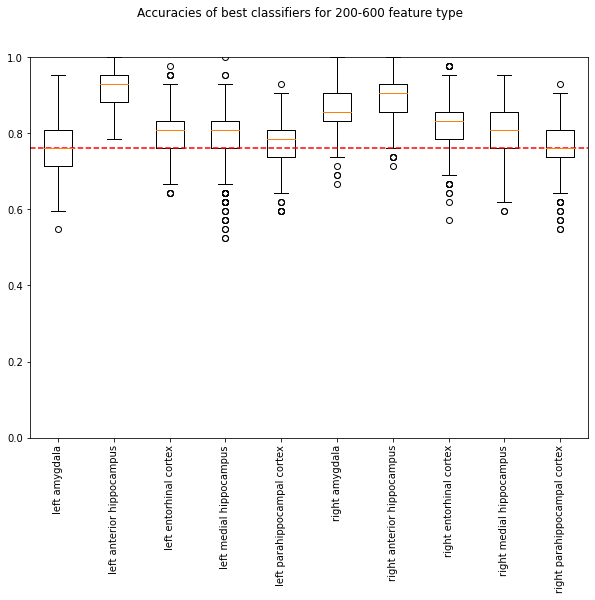

In [58]:
#print best clfs per area
mean_accuracies = []
std_accuracies = []
accuracies = []
for i in range(len(brain_areas)):
    brain_area = brain_areas[i]
    print(f'brain area: {brain_area}')
    best_clf = best_clfs[i]
    one_area = []
    
    for sublist in all_losses:
        if sublist[1] == brain_area:
            one_area.append(sublist[0])
    one_area = [item for sublist in one_area for item in sublist]

    acc=[]
    for sublist in one_area:
        if (sublist[2] == best_clf[-1]) and (sublist[3] == best_clf[:-1]):
            acc.append(sublist[0])
    accuracies.append(acc)
    mean_accuracies.append(np.mean(acc))
    std_accuracies.append(np.std(acc))
        
    print(f'best classifier: {best_clf}')
    print(f'{mean_accuracies[i]}')

    #plot
fig = plt.figure(figsize =(10, 7))
string = f'Accuracies of best classifiers for {feature_type} feature type'
fig.suptitle(string)
# Creating plot
plt.boxplot(accuracies, labels=brain_areas)
plt.ylim(0,1)
plt.axhline(movie_stim_percentage/100, c='r', linestyle='--')
plt.xticks(rotation=90)
plt.show()
fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots_best/Accuracies of best classifiers for {feature_type} feature type.png',facecolor='white', transparent=False)       

left amygdala
left anterior hippocampus
left entorhinal cortex
left medial hippocampus
left parahippocampal cortex
right amygdala
right anterior hippocampus
right entorhinal cortex
right medial hippocampus
right parahippocampal cortex


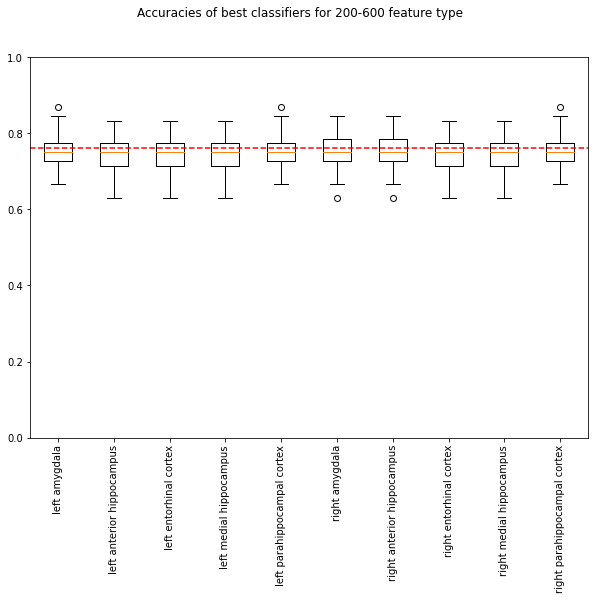

In [63]:
#re-run best classifiers
accuracies = []
random_seeds = np.linspace(1, 500, 100, dtype=int)
for i in range(len(brain_areas)):
    brain_area = brain_areas[i]
    clf = best_clfs[i]
    kernel = clf[-1]
    print(brain_area)
    accuracies_area = []
    for rand_seed in random_seeds:
        np.random.seed(rand_seed) #for train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
        if clf[-1] == 'linear':
            if (clf[2]=='l1') and (clf[1]=='squared_hinge'):
                dual = False
            elif (clf[2]=='l2') and (clf[1]=='hinge'):
                dual = True
            else:
                dual = False
            best_estimator = svm.LinearSVC(penalty=clf[2], loss=clf[1], C=clf[0], dual=dual, random_state=rand_seed).fit(X_train, y_train)
            cv = CountVectorizer()
            cv.fit(X_train)
            fig = decoding.plot_coefficients(best_estimator, cv.get_feature_names(), top_features=20)

        else:
            best_estimator = svm.SVC(C=clf[0], kernel=clf[-1], random_state=rand_seed).fit(X_train, y_train)
            perm_importance = permutation_importance(best_estimator, X_test, y_test)
            cv = CountVectorizer()
            cv.fit(X_train)
            feature_names = cv.get_feature_names()
            fig = decoding.plot_coefficients_nonlinear(best_estimator, feature_names, X_test, y_test)
        #plt.show()
        fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots_best/{feature_type}/{brain_area}_{kernel}_important_features.png', facecolor='white', transparent=False)
        plt.close()

        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6))
        y_train_score = best_estimator.decision_function(X_train)
        false_pos_rate, true_pos_rate, _ = roc_curve(y_train, y_train_score)
        roc_auc = auc(false_pos_rate, true_pos_rate)
        cc = clf[0]
        ax1.plot(false_pos_rate, true_pos_rate, label=f'{kernel} SVM C={cc} ROC curve (area = {roc_auc:.2f})', color='b')
        ax1.set_title('Training Data')

        y_test_score = best_estimator.decision_function(X_test)
        false_pos_rate, true_pos_rate, _ = roc_curve(y_test, y_test_score)
        roc_auc = auc(false_pos_rate, true_pos_rate)
        ax2.plot(false_pos_rate, true_pos_rate, label=f'{kernel} SVM C={cc} ROC curve (area = {roc_auc:.2f})', color='b')
        ax2.set_title('Test Data')
        plt.close()

        for ax in fig.axes:
            ax.plot([0, 1], [0, 1], 'k--')
            ax.set_xlim([-0.05, 1.0])
            ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.legend(loc="lower right")
        fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots_best/{feature_type}/{brain_area}_{kernel}_ROC_curve_best.png', facecolor='white', transparent=False)
        #plt.plot()
        plt.close()

        pred = best_estimator.predict(X_test)
        test_error = np.mean(best_estimator.predict(X_test) != y_test)
        train_accuracy = best_estimator.score(X_train, y_train)
        test_accuracy = best_estimator.score(X_test, y_test)
        f1 = f1_score(y_test, pred, average='weighted')
        cm = sklearn.metrics.confusion_matrix(y_test, pred)
        # Model Precision: what percentage of positive tuples are labeled as such?
        precision = sklearn.metrics.precision_score(y_test, pred)
        # Model Recall: what percentage of positive tuples are labelled as such?
        recall = sklearn.metrics.recall_score(y_test, pred)

        string = f'Test error for {kernel} classifier: {test_error}'
        #print(string)
        strings.append(string)
        string = f'Train accuracy for {kernel} classifier: {train_accuracy*100}'
        #print(string)
        strings.append(string)
        string = f'Test accuracy {kernel} classifier: {test_accuracy*100}'
        #print(string)
        strings.append(string)
        string = f'F1 ({kernel} Kernel): {f1*100}'
        #print(string)
        strings.append(string)
        string = f'Precision: {precision}'
        #print(string)
        strings.append(string)
        string = f'Recall: {recall}'
        #print(string)
        strings.append(string)            
        #print(cm)
        strings.append(cm)
        accuracies_area.append(test_accuracy)
    accuracies.append(accuracies_area)

#accuracies of best classifiers per area
mean_accuracies = []
std_accuracies = []
for i in range(len(brain_areas)):
    acc = accuracies[i]
    mean_accuracies.append(np.mean(acc))
    std_accuracies.append(np.std(acc))

#plot
fig = plt.figure(figsize =(10, 7))
string = f'Accuracies of best classifiers for {feature_type} feature type'
fig.suptitle(string)
# Creating plot
plt.boxplot(accuracies, labels=brain_areas)
plt.ylim(0,1)
plt.axhline(movie_stim_percentage/100, c='r', linestyle='--')
plt.xticks(rotation=90)
plt.show()
fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots_best/Accuracies of best classifiers for {feature_type} feature type.png',facecolor='white', transparent=False)